# Predicting Heart Disease in Patients

Names: Michael Zheng, Zain Imran, Ella Mo, Yuhao Fu

### Introduction

A significant portion of deaths each year can be attributed to heart disease. As such, it is critical and essential to determine the common manifestations of heart disease so that we can better understand the conditions which heart disease can develop from and provide timely treatment. In this project, our group will use the data provided by [Janosi et al](https://doi.org/10.24432/C52P4X). to find the relationship between various potentially related factors and the occurrence of heart disease. In this way, we may predict the diagnosis of heart disease more precisely and efficiently according to these factors.

The variables in in the original table are:
- Age
- Sex
- Chest pain (cp)
- Resting blood pressure in mmHg (trestbps)
- Serum cholesterol in mg/dl (chol)
- Fasting blood sugar in mg/dl (fbs)
- Resting electrocardiography (restecg)
- Maximum heart rate achieved (thalach)
- Exercise induced angina (exang)
- ST depression induced by exercise relative to rest (oldpeak)
- Slope of peak exercise ST segment (slope)
- Number of major vessels(0-3) coloured by fluoroscopy (ca)
- Blood disorder (thal)
- Diagnosis of heart disease (num)


In [23]:
library(tidyverse)
library(repr)
library(tidymodels)
install.packages("kknn")
options(repr.matrix.max.rows = 6)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



 # Reading The Data

In order to read the data we must download the data set from the web. When reading the data set we must name the columns and convert the "ca" and "thal" columns into numerical values as they are in categorical values and will be otherwise unusable for our classification. However many of the variables represent categorical variables so we will list what each categorical variable represents: 
1. sex:     female (0), male (1)
2. cp:      typical angina (1), atypical angina (2), non-anginal pain (3), asymptomatic (4)
3. fbs:     false (0), true (1)
4. restecg: normal (0), having ST-T wave abnormality (1), probable or definite left ventricular hypertrophy by Estes' criteria (2)
5. exang:   no (0), yes (1)
6. slope:   unsloping (1), flat (2), downsloping (3)
7. ca:      number of major vessels coloured (0-3)
8. thal:    normal (3), fixed defect (6), reversable defect (7)

Here we will mutate the diagnosis column into a categorical with either healthy (0) or unhealthy (1-4), remove any values that are not listed using filter. We also convert the "ca" and "thal" columns into numerical values as they are initially categorical values.

In [24]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
heart_disease_data <- read_csv(url, 
                               col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach",
                                             "exang", "oldpeak", "slope", "ca", "thal", "diagnosis")) |> 
                      mutate(diagnosis = as_factor(diagnosis)) |> 
                      mutate(diagnosis = fct_recode(diagnosis, "healthy" = "0", "unhealthy" = "1" , "unhealthy" = "2",
                                                    "unhealthy" = "3" , "unhealthy" = "4")) |>
                      filter(ca != "?") |> 
                      filter(thal != "?") |>
                      mutate(ca = as.numeric(ca)) |>
                      mutate(thal = as.numeric(thal))
heart_disease_data

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,healthy
67,1,4,160,286,0,2,108,1,1.5,2,3,3,unhealthy
67,1,4,120,229,0,2,129,1,2.6,2,2,7,unhealthy
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
68,1,4,144,193,1,0,141,0,3.4,2,2,7,unhealthy
57,1,4,130,131,0,0,115,1,1.2,2,1,7,unhealthy
57,0,2,130,236,0,2,174,0,0.0,2,1,3,unhealthy


Figure 1. Table of the dataset with all variables in numeric form except for diagnosis which we are predicting.

# Splitting the Data

Here we will split the data using a split of 0.75 to train the classifier and see how accurately we can find whether a patient has heart disease or not. The observations and modeling would be done with the training set, and the testing set would be used to verify the accuracy of the model when processing new data. In this case and every other operation involving selection, a set seed of 3456 is used to retain consistency in our selections.

In [25]:
#Here we split the training data to use for our classifications
set.seed(3456)
heart_disease_split <- initial_split(heart_disease_data, prop = 0.75, strata = diagnosis)
heart_disease_training <- training(heart_disease_split)
heart_disease_testing <- testing(heart_disease_split)

# Table of Averages

Here we created a summary table that shows us the averages for the age, resting blood pressure, serum cholesterol levels, maximum heart rate, and the ST depression induced by exercise. This table lets us understand that patients who have variables within certain ranges are more likely to be healthy or unhealthy and also lets us see which variables have a larger variability in the data. We will be using these variables in the table as they are quantitative and do not represent specific categories.

In [34]:
heart_disease_average_table <- heart_disease_training |> 
                                group_by(diagnosis) |>
                                summarize(age = mean(age), trestbps = mean(trestbps), chol = mean(chol), thalach = mean(thalach), 
                                          oldpeak = mean(oldpeak))
heart_disease_average_table

diagnosis,age,trestbps,chol,thalach,oldpeak
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
healthy,52.29167,129.4750,239.6500,158.8417,0.625000
unhealthy,56.91176,135.3725,253.8137,138.0588,1.679412


Figure 2. Table of the the average values of a healthy vs. unhealthy individual

# Graphing the Data

### Histograms

We decided to graph all the variables to see which ones play a significant role in the predictability of heart disease in a patient. We left the two that we determined to be the strongest (age and thalach). From the graphs we determined that we will not be using the "sex" or "fbs" variables in our classifier as they do not appear to play a significant role in the determination of heart disease in a patient. 

Warning message in geom_histogram(stat = "count", alpha = 0.7):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”
Warning message in geom_histogram(stat = "count"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”
Warning message in geom_histogram(stat = "count"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”
Warning message in geom_histogram(stat = "count", alpha = 0.7):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”
Warning message in geom_histogram(stat = "count", alpha = 0.7):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”
Warning message in geom_histogram(stat = "count"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”
Warning message in geom_histogram(stat = "count"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”
Warning message in geom_histogram(stat = "count", alpha = 0.7):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”
Warning message in geom_histogram(stat = "count"):
“

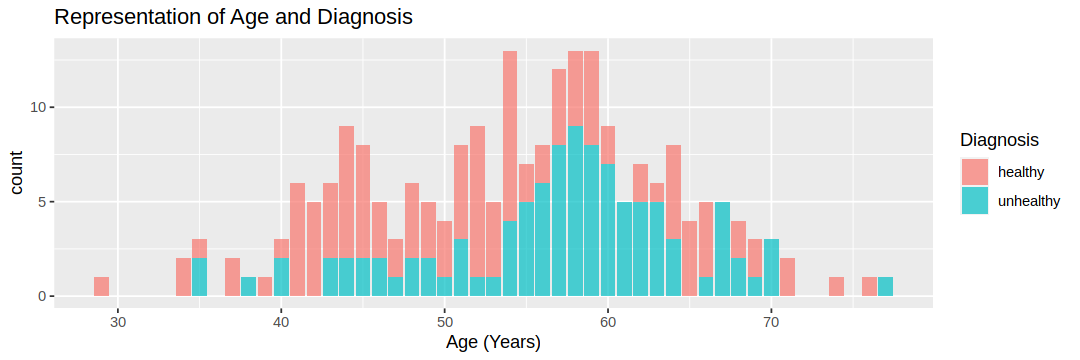

In [35]:
# A bar graph of each variable in relation to the diagnosis
# we have commented out all  our graphs but one for improved readability if we want to see said graphs we can uncomment the graph
options(repr.plot.width = 9, repr.plot.height = 3)

heart_disease_age_graph <- ggplot(heart_disease_training, aes(x = age, fill = diagnosis)) + 
                           geom_histogram(stat = "count", alpha = 0.7) + 
                           ggtitle("Representation of Age and Diagnosis") + 
                           labs(x = "Age (Years)", fill = "Diagnosis", stat = "Count")
heart_disease_cp_graph <- ggplot(heart_disease_training, aes(x = cp, fill = diagnosis)) + 
                           geom_histogram(stat = "count") + 
                           ggtitle("Representation of Chest Pain Types and Diagnosis") + 
                           labs(x = "Chest Pain Types", fill = "Diagnosis", stat = "Count")
heart_disease_sex_graph <- ggplot(heart_disease_training, aes(x = sex, fill = diagnosis)) + 
                           geom_histogram(stat = "count") + 
                           ggtitle("Representation of Sex and Diagnosis") + 
                           labs(x = "Sex", fill = "Diagnosis", stat = "Count")
heart_disease_trestbps_graph <- ggplot(heart_disease_training, aes(x = trestbps, fill = diagnosis)) + 
                           geom_histogram(stat = "count", alpha = 0.7) + 
                           ggtitle("Representation of Resting Blood Pressure and Diagnosis") + 
                           labs(x = "Resting Blood Pressure (mmHg)", fill = "Diagnosis", stat = "Count")
heart_disease_chol_graph <- ggplot(heart_disease_training, aes(x = chol, fill = diagnosis)) + 
                           geom_histogram(stat = "count", alpha = 0.7) + 
                           ggtitle("Representation of Serum Cholesterol and Diagnosis") + 
                           labs(x = "Serum Cholesterol (mg/dl)", fill = "Diagnosis", stat = "Count")
heart_disease_fbs_graph <- ggplot(heart_disease_training, aes(x = fbs, fill = diagnosis)) + 
                           geom_histogram(stat = "count") + 
                           ggtitle("Representation of Fasting Blood Sugar and Diagnosis") + 
                           labs(x = "Fasting Blood Sugar (> 120mg/dl)", fill = "Diagnosis", stat = "Count")
heart_disease_restecg_graph <- ggplot(heart_disease_training, aes(x = restecg, fill = diagnosis)) + 
                           geom_histogram(stat = "count") + 
                           ggtitle("Representation of Resting ECG Results and Diagnosis") + 
                           labs(x = "Resting ECG Results", fill = "Diagnosis", stat = "Count")
heart_disease_thalach_graph <- ggplot(heart_disease_training, aes(x = thalach, fill = diagnosis)) + 
                           geom_histogram(stat = "count", alpha = 0.7) + 
                           ggtitle("Representation of Max Heart Rate and Diagnosis") + 
                           labs(x = "Max Heart Rate (bpm)", fill = "Diagnosis", stat = "Count")
heart_disease_exang_graph <- ggplot(heart_disease_training, aes(x = exang, fill = diagnosis)) + 
                           geom_histogram(stat = "count") + 
                           ggtitle("Representation of Exercised Induced Angina and Diagnosis") + 
                           labs(x = "Exercised Induced Angina", fill = "Diagnosis", stat = "Count")
heart_disease_oldpeak_graph <- ggplot(heart_disease_training, aes(x = oldpeak, fill = diagnosis)) + 
                           geom_histogram(stat = "count", alpha = 0.7) + 
                           ggtitle("Representation of ST Depression and Diagnosis") + 
                           labs(x = "ST Depression Relative To Rest", fill = "Diagnosis", stat = "Count")
heart_disease_slope_graph <- ggplot(heart_disease_training, aes(x = slope, fill = diagnosis)) + 
                           geom_histogram(stat = "count") + 
                           ggtitle("Representation of Slope of Peak Exercise ST and Diagnosis") + 
                           labs(x = "Slope of Peak Exercise ST", fill = "Diagnosis", stat = "Count")
heart_disease_ca_graph <- ggplot(heart_disease_training, aes(x = ca, fill = diagnosis)) + 
                           geom_histogram(stat = "count") + 
                           ggtitle("Representation of Number of Major Vessels and Diagnosis") + 
                           labs(x = "Number of Major Vessels Colored By Fluoroscopy", fill = "Diagnosis", stat = "Count")
heart_disease_thal_graph <- ggplot(heart_disease_training, aes(x = thal, fill = diagnosis)) + 
                           geom_histogram(stat = "count") + 
                           ggtitle("Representation of Defect Type and Diagnosis") + 
                           labs(x = "Defect Type", fill = "Diagnosis", stat = "Count")
heart_disease_age_graph
#heart_disease_cp_graph
#heart_disease_sex_graph
#heart_disease_trestbps_graph
#heart_disease_chol_graph
#heart_disease_fbs_graph
#heart_disease_restecg_graph
#heart_disease_exang_graph
#heart_disease_oldpeak_graph
#heart_disease_slope_graph
#heart_disease_ca_graph
#heart_disease_thal_graph

Graph 1. Histogram of the age of patients and the healthy and unhealthy count.

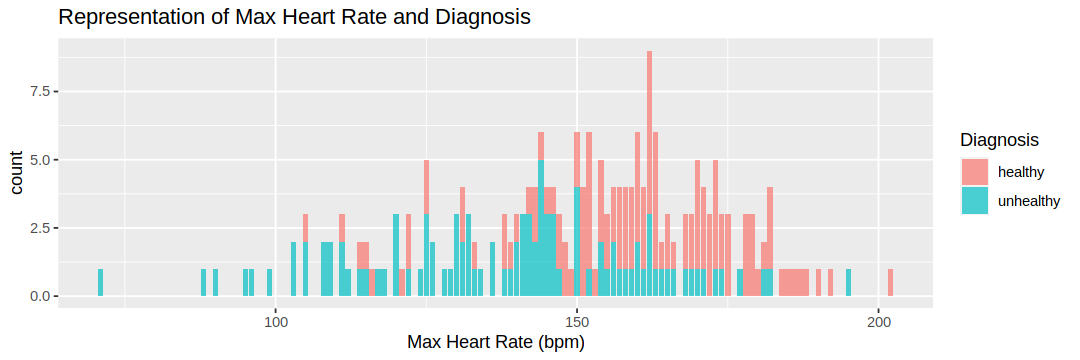

In [36]:
heart_disease_thalach_graph

Graph 2. Histogram for the maximum heart rate and the healthy and unhealthy counts.

In Graph 1, the healthy portion of the column is larger than the unhealthy part when the age is smaller than 54. However, the unhealthy portion plays a more important role when the age is greater than 55. In this way, we can conclude that age has a great impact on the probability of heart disease. In fact, age forms a positive relationship with the probability of heart disease. However, in Graph 2, the unhealthy portion is larger when the maximum heart rate is lower than 148 and decreases when the maximum heart rate increases, so we can analyze that the maximum heart rate forms a negative relationship with the probability of heart disease, which is different with the relationship found in Graph 1.

### Scatter Plot

Here we will visualize the relationship between the two variables above ("age" and "thalach") in order to help us understand what type of relationship exists between some of the variables. 

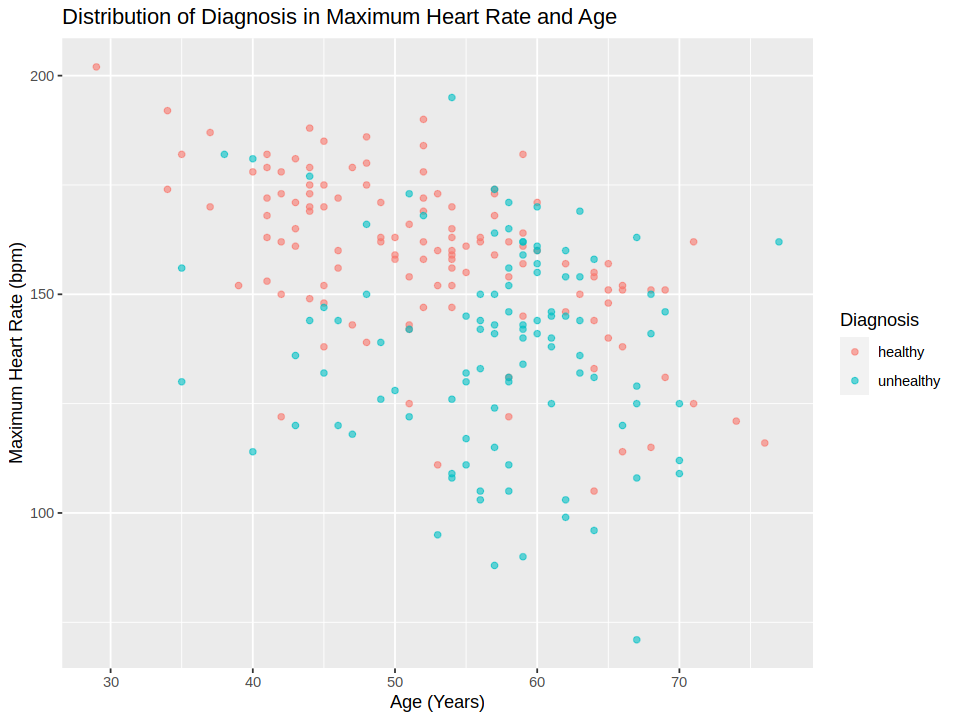

In [37]:
set.seed(3456)
options(repr.plot.width = 8, repr.plot.height = 6)
age_v_mhr <- ggplot(heart_disease_training, aes(x = age, y = thalach)) + 
            geom_point(aes(colour = diagnosis), alpha = 0.6) + 
            labs(x = "Age (Years)", y = "Maximum Heart Rate (bpm)",  color = "Diagnosis") +
            ggtitle("Distribution of Diagnosis in Maximum Heart Rate and Age")
age_v_mhr

Graph 3. Scatter plot showing the age and maximum heart rate distribution across the healthy and unhealthy samples.

Throughout the observation of the graph for age versus maximum heart rate, we can find the pattern and intervals of healthy and unhealthy. A healthy range for maximum heart rates falls between 150 and 180. The majority of data points representing healthy individuals cluster between the ages of 33 and 55, aligning with a maximum heart rate within the healthy range. The unhealthy points are most dense at age 55–70, with a maximum heart rate of 100 to 150. 
The patients that fit the range of healthy would be less likely to have heart disease, and the ones that fulfill unhealthy intervals are more likely to have heart disease.

# Classification

### Cross-fold Validation

Here we will create and tune the classifier by creating the recipe in which we will use 11 of the 13 variables and will not be using sex or fasting blood sugar (fbs). We will create the tuning model for the k-nearest-neighbours algorithm and will perform a 5-fold cross validation. We will be looking at all the odd K values from 1 to 29 as this will let us choose the most accurate K value. We will then visualize our results of the accuracy of each K value in a table.

In [30]:
heart_disease_recipe = recipe(diagnosis ~ ., select(heart_disease_training, -sex, -fbs)) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_tuning = nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

set.seed(3456)
heart_disease_vfold = vfold_cv(heart_disease_training, v = 5, strata = diagnosis)
k_vals = tibble(neighbors = seq(1, 29, 2))

tuning_workflow = workflow() |>
       add_recipe(heart_disease_recipe) |>
       add_model(knn_tuning) |>
       tune_grid(resamples = heart_disease_vfold, grid = k_vals)

tuning_metrics = tuning_workflow |>
    collect_metrics()

accuracies <- tuning_metrics |> 
    filter(.metric == "accuracy") |>
    select(neighbors, mean)
options(repr.matrix.max.rows = 15)
accuracies

neighbors,mean
<dbl>,<dbl>
1,0.7794949
3,0.8156566
5,0.8159596
7,0.8158586
9,0.8427273
11,0.8473737
13,0.8473737
15,0.8473737
17,0.8564646


Figure 3. Table of mean accuracy for all k-values tested.

Here we will graph the accuracy as a function of neighbours so that we can choose the K value with the highest accuracy. We will then use said K value to determine the accuracy in the testing data.

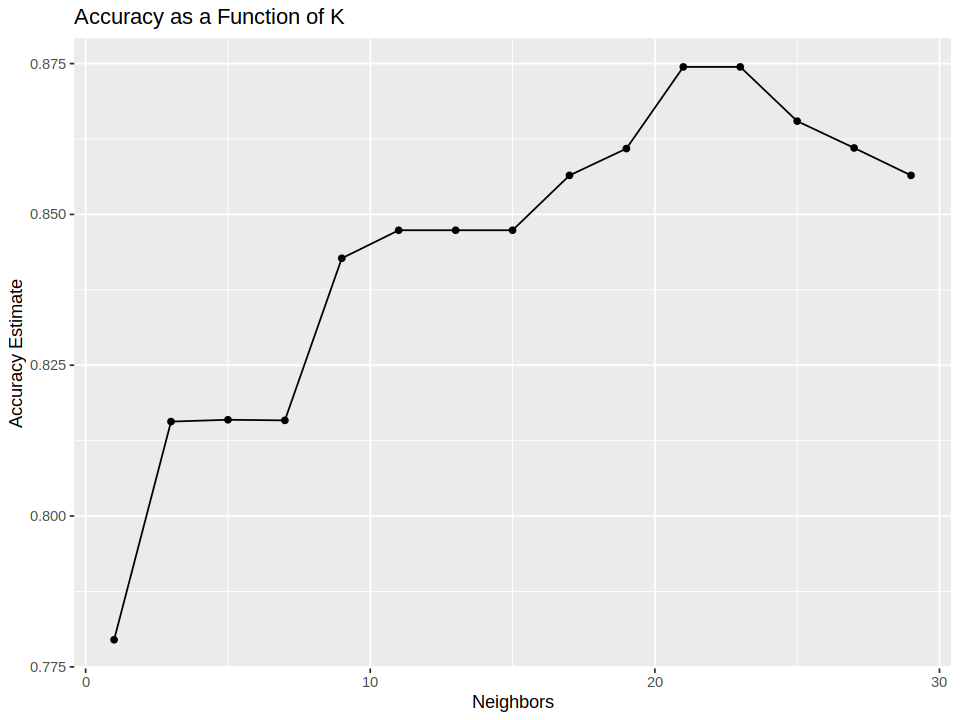

In [38]:
accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    ggtitle("Accuracy as a Function of K")
accuracy_versus_k

Graph 4. Line plot of k-values against their accuracy

From here we will choose a K value of 21 as it appears to be the most accurate value in the graph. We will then use the K value in the training data set to determine the accuracy of our classifier. 

### Training Model

Here we train the model based on a k-value of 21. The model uses a k-nearest neighbour algorithm on the training data set, and compares any new observation it is predicting to the nearest 21 observations in the training data set. The first round of testing the validity of the model was done by giving it the same training set it was trained on. Of the 222 observations in the training set, the model corrected predicted 81 cases of heart disease and 110 healthy cases, with the incorrect predictions including 10 false positives and 21 false negatives, overall resulting in an accuracy of 86%.

In [32]:
set.seed(3456)

knn_spec = nearest_neighbor(weight_func = "rectangular", neighbors = 21) |>
            set_engine("kknn") |>
            set_mode("classification")

heart_disease_fit = workflow() |>
    add_recipe(heart_disease_recipe) |>
    add_model(knn_spec) |>
    fit(heart_disease_training)

heart_disease_train = heart_disease_fit |>
    predict(heart_disease_training) |>
    bind_cols(heart_disease_training)

heart_disease_conf_mat = heart_disease_train |>
    conf_mat(diagnosis, .pred_class)

heart_disease_accuracy = heart_disease_train |>
    metrics(truth = diagnosis, estimate = .pred_class) |>
    filter(.metric == "accuracy") |>
    select(.estimate) |>
    pull()

heart_disease_accuracy
heart_disease_conf_mat

[1] 0.8603604

           Truth
Prediction  healthy unhealthy
  healthy       110        21
  unhealthy      10        81

Figure 4. Confusion matrix for the model's prediction of the training set. The value 0.860... represents the accuracy.

### Testing Model

The second round of testing is done with the testing set, which would serve as an independent data set which it was not trained with. Of the 75 observations in the testing set, the model correctly predicted 21 unhealthy cases and 36 healthy cases and returned 4 false positives and 14 false negatives, resulting in an accuracy of 76%.

In [33]:
heart_disease_test = heart_disease_fit |>
    predict(heart_disease_testing) |>
    bind_cols(heart_disease_testing)

heart_disease_test_conf_mat = heart_disease_test |>
    conf_mat(diagnosis, .pred_class)

heart_disease_test_accuracy <- heart_disease_test |>
  metrics(truth = diagnosis, estimate = .pred_class) |>
  filter(.metric == "accuracy") |>
  select(.estimate) |>
  pull()
heart_disease_test_accuracy

heart_disease_test_conf_mat

[1] 0.76

           Truth
Prediction  healthy unhealthy
  healthy        36        14
  unhealthy       4        21

Figure 5. Confusion matrix for the model's prediction of the testing set. The value 0.76 represents the accuracy.

# Discussion

### Summary

Overall, we can conclude that all of the factors we chose have a significant impact on the heart disease probability. After doing classification, we found that the accuracy reaches the highest point when K = 21 in the graph. After applying the k-nearest neighbour model, we got the value that the training set has an accuracy of 86%, which shows a strong correlation. And the testing set reaches an accuracy of 76%, which shows an observable correlation but not as strong as the training set. This may be caused by the use of V = 5 in the Cross-fold Validation. In addition, the split of data is 0.75 which can also lead to the difference between the training set and the testing set.

### Expected Findings

We are expecting to find a strong relationship between heart disease and all of the predictors. However, we have removed variables that we believe are not playing the most significant role in predicting heart disease in patients.

### Impacts of Findings

This finding has high significance as it can provide doctors with a guide. With the help of the data, doctors can have a brief idea on the conditions of the patients. This can help patients have a general understanding of their physical conditions and be informed of potential factors correlating to heart disease. Furthermore, these findings can encourage potential patients to get check-ups and potential early treatment.

### Future Questions

**Which factors are affected by biological aspects and which are affected by lifestyles?**

Since all variables in the list could make some difference in the result of a person being more likely to have heart disease or not, We could also find whether biological aspects or lifestyle affect heart disease the most.

**Which factor plays the greatest role in heart disease determination?**

We want to find which factor plays the most important role in causing heart disease, so this could raise awareness among patients and encourage them to check the specific factor often.

**Does this relation vary by region?**

The environment and country where patients live and the habits in those countries could have a significant impact on heart disease, and we want to know whether there are any underlying factors in a region that will make patients more likely to have heart disease.

# References

Janosi, A., Steinbrunn, W., Pfisterer, M., Detrano, R. (1988). *Heart Disease*. UCI Machine Learning Repository. https://doi.org/10.24432/C52P4X.

Tiffany Timbers, T. C. (2023, August 31). Data science. Chapter 6 Classification II: evaluation & tuning. http://datasciencebook.ca/classification2.html#tuning-the-classifier 